# TD Bank - Stock Prices Prediction

## 1. Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas_datareader as webreader
import pandas as pd
import tensorflow as tf
import time
import seaborn as sns
import datetime as dt
import requests

from datetime import date, timedelta, datetime
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader import data
from tensorflow import keras

In [2]:
# Start run time
start_time = time.time()

## 2. Data Preprocessing and Visualization

### 2.1. Load Data

In [3]:
# !pip install --upgrade pandas
# !pip install --upgrade pandas-datareader

In [4]:
# Import dataset
try:
  # Load dataframe (df) into appropriate format
  df_old = pd.read_csv('TD-Stocks-2015-2023.csv')
  # Remove unnamed columns identified by (;)
  df_old = df_old.loc[:, ~df_old.columns.str.match('^Unnamed')]
except:
  # No data found
  print("Data not found. Please try again.")

# today = date.today()
# date_today = today.strftime("%Y-%m-%d")
# date_start = '2015-03-11'

# # Read stock quotes from Yahoo Finance
# df = data.DataReader('TD.TO', data_source='yahoo', start=date_start, end=date_today)

### 2.2. Analyze Data

In [5]:
df_old

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-21,55.040001,55.299999,54.419998,54.799999,40.216873,4098700
1,2015-12-22,54.900002,54.900002,54.169998,54.599998,40.070103,2543600
2,2015-12-23,54.799999,55.020000,54.529999,54.869999,40.268242,2446900
3,2015-12-24,54.750000,55.130001,54.750000,55.029999,40.385674,1112800
4,2015-12-29,55.169998,55.430000,55.040001,55.330002,40.605831,1850400
...,...,...,...,...,...,...,...
2002,2023-12-13,81.019997,82.589996,80.349998,82.589996,82.589996,10430800
2003,2023-12-14,83.099998,84.370003,83.080002,84.349998,84.349998,10339600
2004,2023-12-15,84.940002,84.940002,83.379997,83.519997,83.519997,18199100
2005,2023-12-18,83.000000,83.669998,82.970001,83.000000,83.000000,5194200


In [6]:
# Brief info about dataframe - non-null values and datatype
df_old.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2007 entries, 0 to 2006
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2007 non-null   object 
 1   Open       2007 non-null   float64
 2   High       2007 non-null   float64
 3   Low        2007 non-null   float64
 4   Close      2007 non-null   float64
 5   Adj Close  2007 non-null   float64
 6   Volume     2007 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 109.9+ KB


In [7]:
# Check for missing values
df_old.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
# Drop/impute missing values (if required)
df_old = df_old.dropna(how='any', axis=0)

# Verify is successful
df_old.isnull().sum()

# imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
# imputer.fit_transform(dataset)
# dataset = imputer.transform(dataset)
# df_old.dropna(inplace=True)

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:
# Window size
win = 7

In [10]:
# Compute rolling averages and append to existing dataframe (df)

# Date
dates = []
# Get current date
current_date = pd.to_datetime(df_old['Date'].iloc[-1], format='%Y-%m-%d').date()
# Append next "win" days
for i in range(0, win):
  current_date += timedelta(days=1)
  dates.append(current_date)
# Convert to Pandas DataFrame
dates = pd.to_datetime(dates, format='%Y-%m-%d')
next_days = pd.DataFrame(dates)
# Append to new dataframe
df_date = pd.concat([df_old['Date'], next_days], ignore_index=True)

# Open stock price
rolling_open = df_old['Open'].rolling(window=win).mean()[(-win-1):-1]
# rolling_open = pd.DataFrame(rolling_open)
# Append to new dataframe
df_open = pd.concat([df_old['Open'], rolling_open], ignore_index=True)

# High stock price
rolling_high = df_old['High'].rolling(window=win).mean()[(-win-1):-1]
# Append to new dataframe
df_high = pd.concat([df_old['High'], rolling_high], ignore_index=True)

# Low stock price
rolling_low = df_old['Low'].rolling(window=win).mean()[(-win-1):-1]
# Append to new dataframe
df_low = pd.concat([df_old['Low'], rolling_low], ignore_index=True)

# Closing stock price (dependent variable)
rolling_close = df_old['Close'].rolling(window=win).mean()[(-win-1):-1]
# Append to new dataframe
df_close = pd.concat([df_old['Close'], rolling_close], ignore_index=True)

# Adjusted closing stock price
rolling_adj_close = df_old['Adj Close'].rolling(window=win).mean()[(-win-1):-1]
# Append to new dataframe
df_adj_close = pd.concat([df_old['Adj Close'], rolling_adj_close], ignore_index=True)

# Volume of stocks
rolling_volume = df_old['Volume'].rolling(window=win).mean()[(-win-1):-1]
# Append to new dataframe
df_volume = pd.concat([df_old['Volume'], rolling_volume], ignore_index=True)

# New dataframe
df = pd.concat([df_date, df_open, df_high, df_low, df_close, df_adj_close, df_volume], axis=1)
# Rename first column
# [0, 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
df = df.rename(columns={df.columns[0]: "Date", df.columns[1]: "Open", df.columns[2]: "High",
                        df.columns[3]: "Low", df.columns[4]: "Close", df.columns[5]: "Adj Close",
                        df.columns[6]: "Volume"})

In [11]:
df.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume
2004,2023-12-15,84.940002,84.940002,83.379997,83.519997,83.519997,1.819910e+07
2005,2023-12-18,83.000000,83.669998,82.970001,83.000000,83.000000,5.194200e+06
2006,2023-12-19,83.250000,84.709999,83.250000,84.620003,84.620003,3.948100e+06
2007,2023-12-20 00:00:00,82.168571,82.614284,81.247143,81.838572,81.838572,5.592957e+06
2008,2023-12-21 00:00:00,81.840000,82.334284,81.109999,81.701429,81.701429,5.076071e+06
2009,2023-12-22 00:00:00,81.682857,82.199999,80.985713,81.580000,81.580000,5.655186e+06
2010,2023-12-23 00:00:00,81.597142,82.209999,80.844285,81.628571,81.628571,6.770214e+06
2011,2023-12-24 00:00:00,81.771428,82.474286,81.062856,81.961428,81.961428,7.681400e+06
2012,2023-12-25 00:00:00,82.132856,82.771429,81.229999,82.141427,82.141427,9.679371e+06
2013,2023-12-26 00:00:00,82.257142,82.960000,81.669999,82.472856,82.472856,9.329429e+06


In [12]:
# Dataframe statistics on quantitative (numerical) values
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2014.000000,2014.000000,2014.000000,2014.000000,2014.000000,2.014000e+03
mean,74.636981,75.096755,74.154300,74.634421,65.126159,4.492987e+06
std,11.876605,11.944852,11.825055,11.880478,15.258912,3.158861e+06
min,49.110001,49.209999,48.520000,49.020000,36.321194,4.116000e+05
25%,65.599998,65.919998,65.102499,65.470001,52.993978,2.564100e+06
50%,74.750000,75.000000,74.354999,74.774998,62.377067,3.472550e+06
75%,82.785000,83.390002,82.280001,82.767498,79.546736,5.241000e+06
max,107.800003,109.080002,107.279999,107.839996,101.094154,2.547830e+07


In [13]:
# Input data of np array - Closing price
dataset = df.iloc[:, 4:5].values

# Dataset shape
print(dataset.shape)

(2014, 1)


### 2.3. Visualize Data

#### Pariwise relationship between features

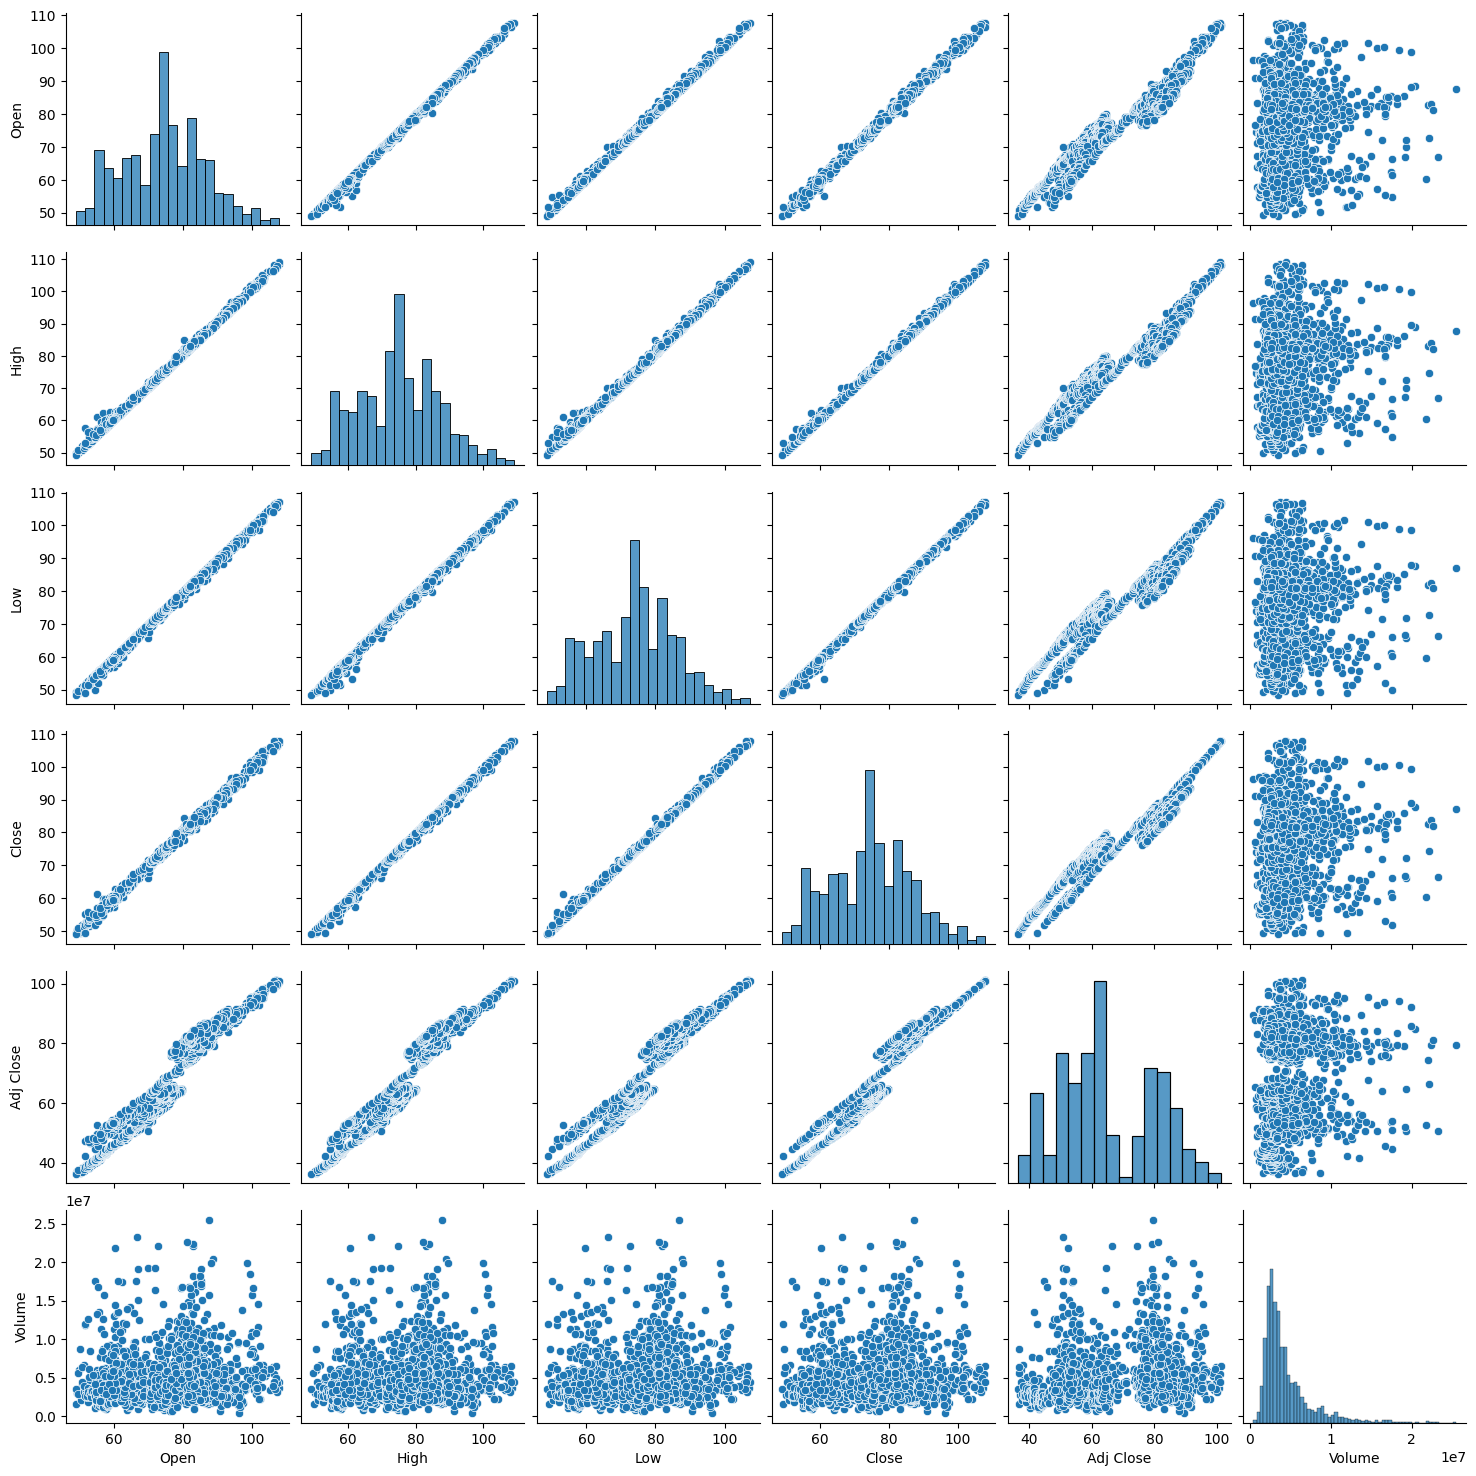

In [14]:
# Pairwise distributions
sns.pairplot(df)

# Show figure
plt.show()

#### Correlation Map

<ipython-input-15-4ffa7bfed554>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(method='pearson'), annot=True, cmap='YlGn', fmt='.2f')


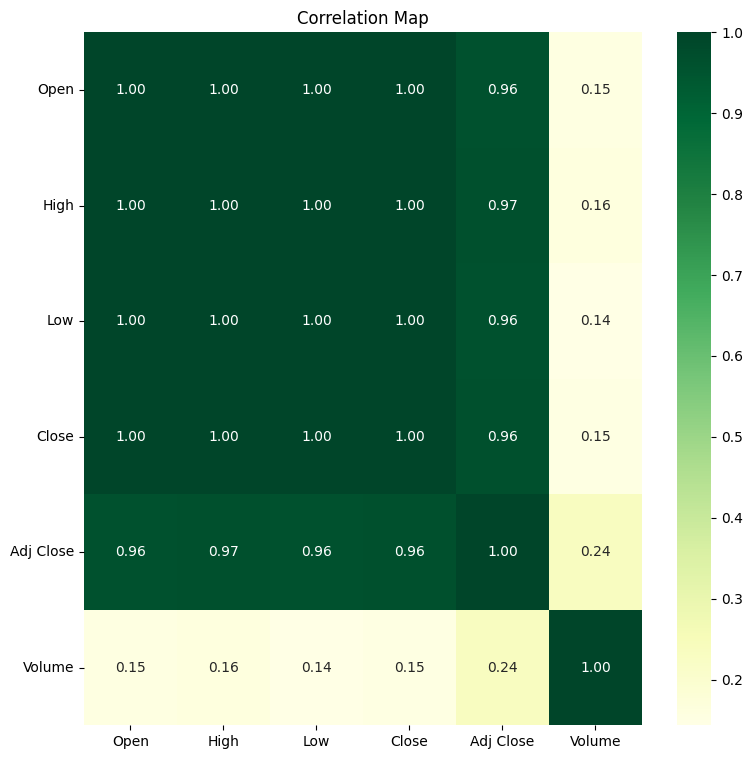

In [15]:
# Define figure
plt.figure(figsize=(9,9))

# Correlation Map
sns.heatmap(df.corr(method='pearson'), annot=True, cmap='YlGn', fmt='.2f')
# Adjust X and Y-Axes
plt.xticks(rotation=0)
plt.yticks(rotation=0)
# Plot title
plt.title('Correlation Map')

# Show figure
plt.show()

#### Individual stock prices and volume distribution

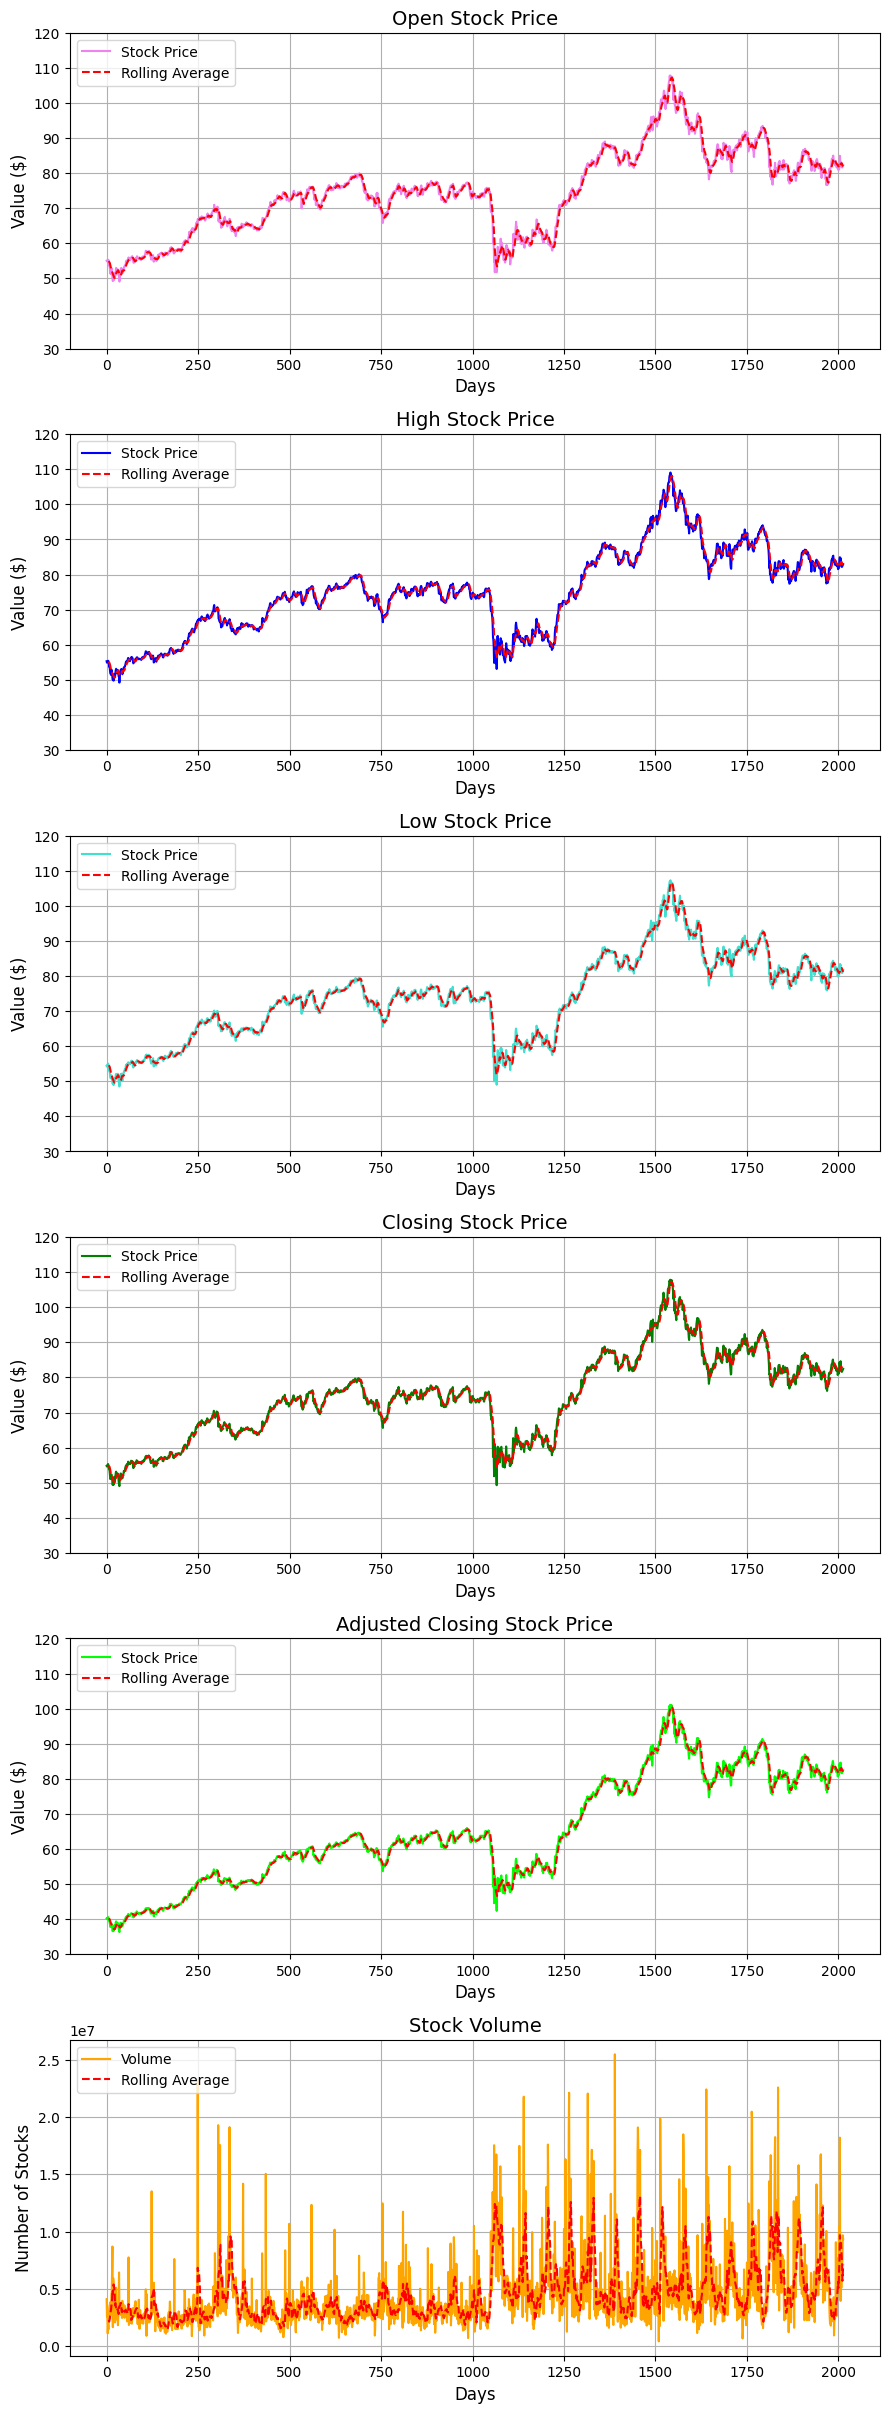

In [16]:
# Define stock prices figure
td_stock_prices = plt.figure(figsize=(9,24))

# Open Stock Price
ax1 = td_stock_prices.add_subplot(6, 1, 1)
ax1 = plt.plot(df['Open'], color = 'violet', label = 'Stock Price')
# Rolling Average
ax1 = plt.plot(df['Open'].rolling(window=7).mean(), "--", color = 'red', label = 'Rolling Average')
# Adjust axes range(s)
# plt.xticks(np.arange(0, 2250, 250))
plt.yticks(np.arange(30, 130, 10))
# Adjust spacing
plt.tight_layout()
# Plot title and labels
plt.xlabel('Days', fontsize=12)
plt.ylabel('Value ($)', fontsize=12)
plt.title('Open Stock Price', fontsize=14)
# Plot legend and grid
plt.legend(loc = 'upper left')
plt.grid(True)

# High Stock Price
ax2 = td_stock_prices.add_subplot(6, 1, 2)
ax2 = plt.plot(df['High'], color = 'blue', label = 'Stock Price')
# Rolling Average
ax2 = plt.plot(df['High'].rolling(window=7).mean(), "--", color = 'red', label = 'Rolling Average')
# Adjust axes range(s)
# plt.xticks(np.arange(0, 2250, 250))
plt.yticks(np.arange(30, 130, 10))
# Adjust spacing
plt.tight_layout()
# Plot title and labels
plt.xlabel('Days', fontsize=12)
plt.ylabel('Value ($)', fontsize=12)
plt.title('High Stock Price', fontsize=14)
# Plot legend and grid
plt.legend(loc = 'upper left')
plt.grid(True)

# Low Stock Price
ax3 = td_stock_prices.add_subplot(6, 1, 3)
ax3 = plt.plot(df['Low'], color = 'turquoise', label = 'Stock Price')
# Rolling Average
ax3 = plt.plot(df['Low'].rolling(window=7).mean(), "--", color = 'red', label = 'Rolling Average')
# Adjust axes range(s)
# plt.xticks(np.arange(0, 2250, 250))
plt.yticks(np.arange(30, 130, 10))
# Adjust spacing
plt.tight_layout()
# Plot title and labels
plt.xlabel('Days', fontsize=12)
plt.ylabel('Value ($)', fontsize=12)
plt.title('Low Stock Price', fontsize=14)
# Plot legend and grid
plt.legend(loc = 'upper left')
plt.grid(True)

# Closing Stock Price (target variable)
ax4 = td_stock_prices.add_subplot(6, 1, 4)
ax4 = plt.plot(df['Close'], color = 'green', label = 'Stock Price')
# Rolling Average
ax4 = plt.plot(df['Close'].rolling(window=7).mean(), "--", color = 'red', label = 'Rolling Average')
# Adjust axes range(s)
# plt.xticks(np.arange(0, 2250, 250))
plt.yticks(np.arange(30, 130, 10))
# Adjust spacing
plt.tight_layout()
# Plot title and labels
plt.xlabel('Days', fontsize=12)
plt.ylabel('Value ($)', fontsize=12)
plt.title('Closing Stock Price', fontsize=14)
# Plot legend and grid
plt.legend(loc = 'upper left')
plt.grid(True)

# Adjusting Closing Stock Price
ax5 = td_stock_prices.add_subplot(6, 1, 5)
ax5 = plt.plot(df['Adj Close'], color = 'lime', label = 'Stock Price')
# Rolling Average
ax5 = plt.plot(df['Adj Close'].rolling(window=7).mean(), "--", color = 'red', label = 'Rolling Average')
# Adjust axes range(s)
# plt.xticks(np.arange(0, 2250, 250))
plt.yticks(np.arange(30, 130, 10))
# Adjust spacing
plt.tight_layout()
# Plot title and labels
plt.xlabel('Days', fontsize=12)
plt.ylabel('Value ($)', fontsize=12)
plt.title('Adjusted Closing Stock Price', fontsize=14)
# Plot legend and grid
plt.legend(loc = 'upper left')
plt.grid(True)

# Volume (number of stocks)
ax6 = td_stock_prices.add_subplot(6, 1, 6)
ax6 = plt.plot(df['Volume'], color = 'orange', label = 'Volume')
# Rolling Average
ax6 = plt.plot(df['Volume'].rolling(window=7).mean(), "--", color = 'red', label = 'Rolling Average')
# Adjust axes range(s)
# plt.xticks()
# plt.yticks()
# Adjust spacing
plt.tight_layout()
# Plot title and labels
plt.xlabel('Days', fontsize=12)
plt.ylabel('Number of Stocks', fontsize=12)
plt.title('Stock Volume', fontsize=14)
# Plot legend and grid
plt.legend(loc = 'upper left')
plt.grid(True)

# Show plot
plt.show()

#### Combined distributions

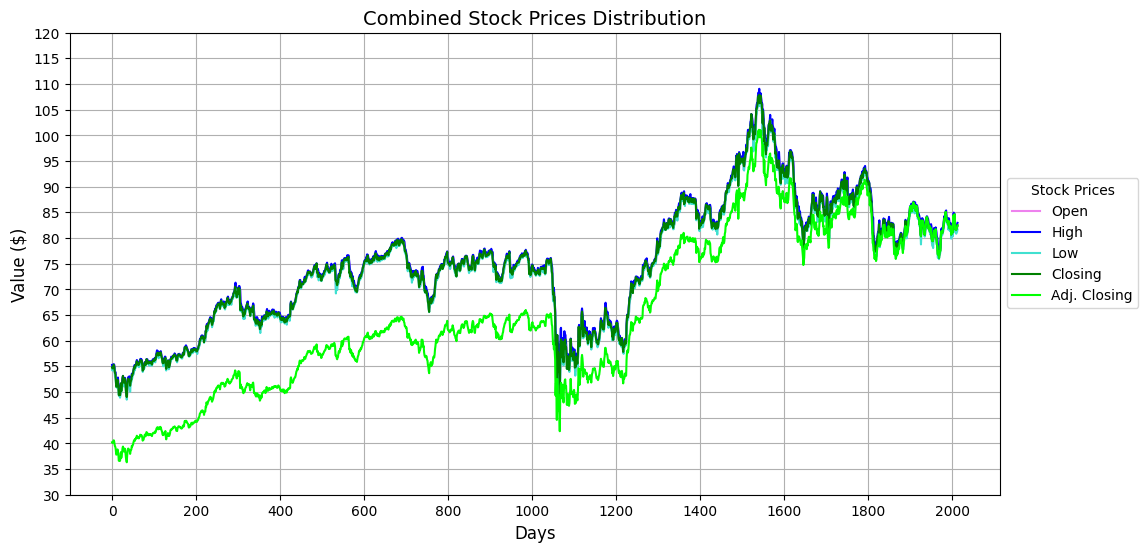

In [17]:
# Define figure
td_stock_prices_comb = plt.figure(figsize=(12,6))

# Open Stock Price
td_stock_prices_comb = plt.plot(df['Open'], color = 'violet', label = 'Open')
# High Stock Price
td_stock_prices_comb = plt.plot(df['High'], color = 'blue', label = 'High')
# Low Stock Price
td_stock_prices_comb = plt.plot(df['Low'], color = 'turquoise', label = 'Low')
# Closing Stock Price
td_stock_prices_comb = plt.plot(df['Close'], color = 'green', label = 'Closing')
# Adjusted Closing Stock Price
td_stock_prices_comb = plt.plot(df['Adj Close'], color = 'lime',
                                 label = 'Adj. Closing')
# Adjust X and Y-Axes ranges
plt.xticks(np.arange(0, 2200, 200))
plt.yticks(np.arange(30, 125, 5))
# Plot title and labels
plt.xlabel('Days', fontsize=12)
plt.ylabel('Value ($)', fontsize=12)
plt.title('Combined Stock Prices Distribution', fontsize=14)
# Plot legend and grid
plt.legend(title="Stock Prices", bbox_to_anchor=(1, 0.7))
plt.grid(True)

# Show plot
plt.show()

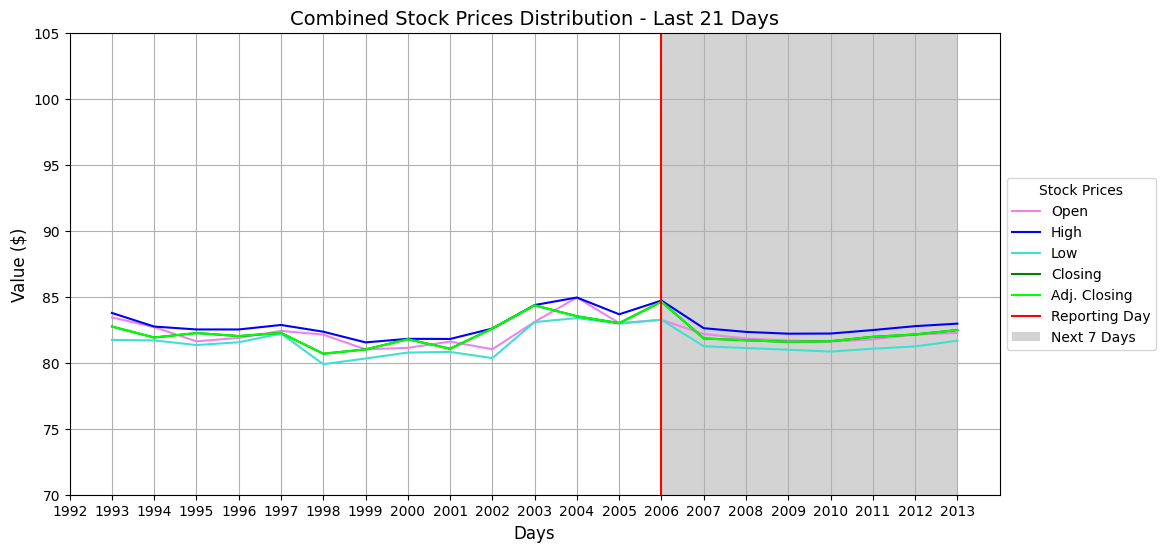

In [18]:
# Define figure - Last 21 days
td_comb_last_21 = plt.figure(figsize=(12,6))

# Open Stock Price
td_comb_last_21 = plt.plot(df['Open'].iloc[-21:], color = 'violet', label = 'Open')
# High Stock Price
td_comb_last_21 = plt.plot(df['High'].iloc[-21:], color = 'blue', label = 'High')
# Low Stock Price
td_comb_last_21 = plt.plot(df['Low'].iloc[-21:], color = 'turquoise', label = 'Low')
# Closing Stock Price
td_comb_last_21 = plt.plot(df['Close'].iloc[-21:], color = 'green', label = 'Closing')
# Adjusted Closing Stock Price
td_comb_last_21 = plt.plot(df['Adj Close'].iloc[-21:], color = 'lime',
                           label = 'Adj. Closing')
# Next 7 days (rolling average region)
td_results_last_21 = plt.axvline(x=(len(df)-(win+1)), color='red', label='Reporting Day')
td_results_last_21 = plt.axvspan(len(df)-8, len(df)-1, facecolor='lightgrey', label='Next 7 Days')

# Adjust X and Y-Axes ranges
# plt.xticks(np.arange(0, 22, 1))
plt.xticks(np.arange(len(df)-22, len(df), 1))
plt.yticks(np.arange(70, 110, 5))
# Plot title and labels
plt.xlabel('Days', fontsize=12)
plt.ylabel('Value ($)', fontsize=12)
plt.title('Combined Stock Prices Distribution - Last 21 Days', fontsize=14)
# Plot legend and grid
plt.legend(title="Stock Prices", bbox_to_anchor=(1, 0.7))
plt.grid(True)

# Show plot
plt.show()

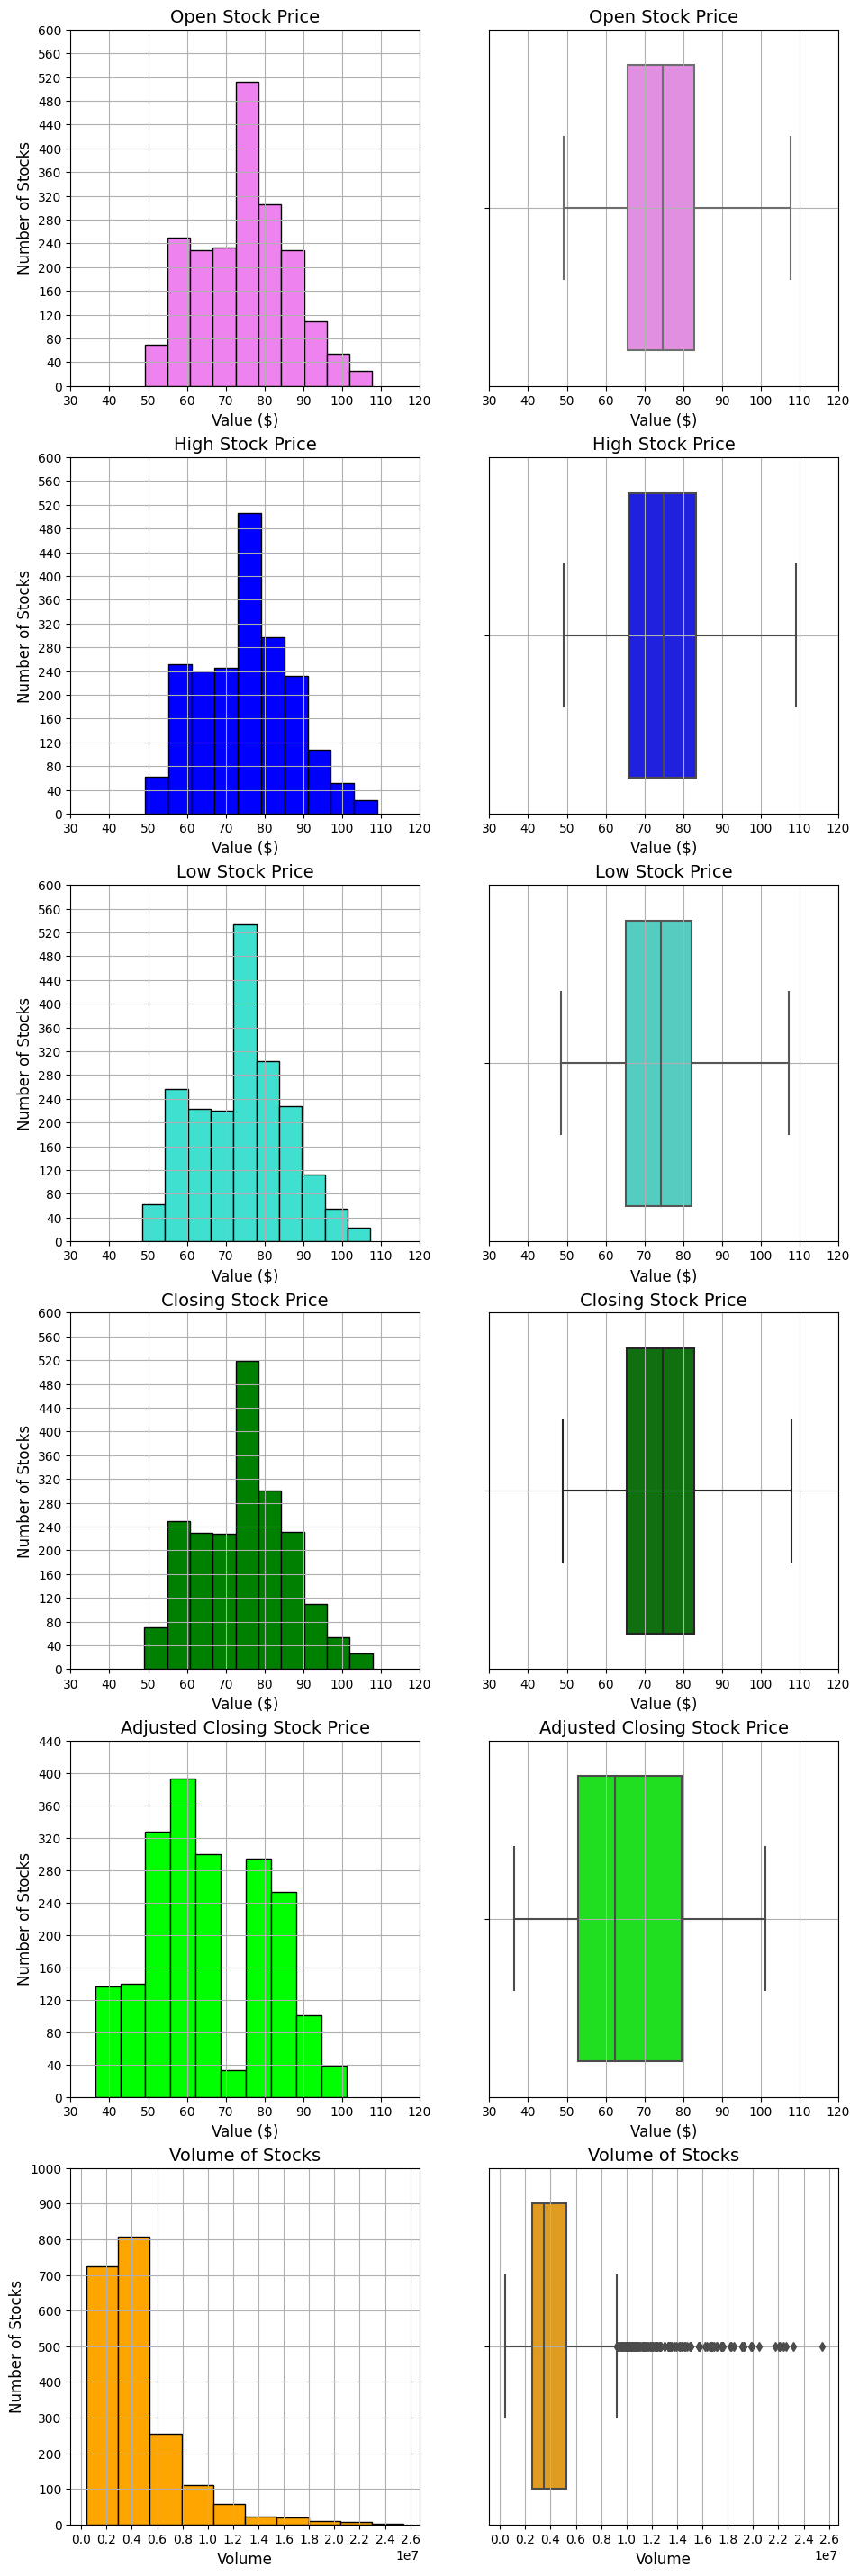

In [19]:
# Define figure
td_comb_dist = plt.figure(figsize=(11, 36))

# -- Open Stock Prices --

# Histogram
ax1 = td_comb_dist.add_subplot(6, 2, 1)
ax1 = plt.hist(x=df['Open'], color='violet', edgecolor='black')
# Adjust axes range(s)
plt.xticks(np.arange(30, 130, 10))
plt.yticks(np.arange(0, 640, 40))
# Plot title and label(s)
plt.xlabel('Value ($)', fontsize=12)
plt.ylabel('Number of Stocks', fontsize=12)
plt.title('Open Stock Price', fontsize=14)
# Plot grid
plt.grid(True)

# Box Plot
ax2 = td_comb_dist.add_subplot(6, 2, 2)
ax2 = sns.boxplot(x=df['Open'], color='violet')
# Adjust X-Axis range(s)
plt.xticks(np.arange(30, 130, 10))
# Plot title and label(s)
plt.xlabel('Value ($)', fontsize=12)
plt.title('Open Stock Price', fontsize=14)
# Plot grid
plt.grid(True)

# -- High Stock Prices --

# Histogram
ax3 = td_comb_dist.add_subplot(6, 2, 3)
ax3 = plt.hist(x=df['High'], color='blue', edgecolor='black')
# Adjust axes range(s)
plt.xticks(np.arange(30, 130, 10))
plt.yticks(np.arange(0, 640, 40))
# Plot title and label(s)
plt.xlabel('Value ($)', fontsize=12)
plt.ylabel('Number of Stocks', fontsize=12)
plt.title('High Stock Price', fontsize=14)
# Plot grid
plt.grid(True)

# Box Plot
ax4 = td_comb_dist.add_subplot(6, 2, 4)
ax4 = sns.boxplot(x=df['High'], color='blue')
# Adjust X-Axis range(s)
plt.xticks(np.arange(30, 130, 10))
# Plot title and label(s)
plt.xlabel('Value ($)', fontsize=12)
plt.title('High Stock Price', fontsize=14)
# Plot grid
plt.grid(True)

# -- Low Stock Prices --

# Histogram
ax5 = td_comb_dist.add_subplot(6, 2, 5)
ax5 = plt.hist(x=df['Low'], color='turquoise', edgecolor='black')
# Adjust axes range(s)
plt.xticks(np.arange(30, 130, 10))
plt.yticks(np.arange(0, 640, 40))
# Plot title and label(s)
plt.xlabel('Value ($)', fontsize=12)
plt.ylabel('Number of Stocks', fontsize=12)
plt.title('Low Stock Price', fontsize=14)
# Plot grid
plt.grid(True)

# Box Plot
ax6 = td_comb_dist.add_subplot(6, 2, 6)
ax6 = sns.boxplot(x=df['Low'], color='turquoise')
# Adjust X-Axis range(s)
plt.xticks(np.arange(30, 130, 10))
# Plot title and label(s)
plt.xlabel('Value ($)', fontsize=12)
plt.title('Low Stock Price', fontsize=14)
# Plot grid
plt.grid(True)

# -- Closing Stock Prices --

# Histogram
ax7 = td_comb_dist.add_subplot(6, 2, 7)
ax7 = plt.hist(x=df['Close'], color='green', edgecolor='black')
# Adjust axes range(s)
plt.xticks(np.arange(30, 130, 10))
plt.yticks(np.arange(0, 640, 40))
# Plot title and label(s)
plt.xlabel('Value ($)', fontsize=12)
plt.ylabel('Number of Stocks', fontsize=12)
plt.title('Closing Stock Price', fontsize=14)
# Plot grid
plt.grid(True)

# Box Plot
ax8 = td_comb_dist.add_subplot(6, 2, 8)
ax8 = sns.boxplot(x=df['Close'], color='green')
# Adjust X-Axis range(s)
plt.xticks(np.arange(30, 130, 10))
# Plot title and label(s)
plt.xlabel('Value ($)', fontsize=12)
plt.title('Closing Stock Price', fontsize=14)
# Plot grid
plt.grid(True)

# -- Adjusted Closing Stock Prices --

# Histogram
ax9 = td_comb_dist.add_subplot(6, 2, 9)
ax9 = plt.hist(x=df['Adj Close'], color='lime', edgecolor='black')
# Adjust axes range(s)
plt.xticks(np.arange(30, 130, 10))
plt.yticks(np.arange(0, 480, 40))
# Plot title and label(s)
plt.xlabel('Value ($)', fontsize=12)
plt.ylabel('Number of Stocks', fontsize=12)
plt.title('Adjusted Closing Stock Price', fontsize=14)
# Plot grid
plt.grid(True)

# Box Plot
ax10 = td_comb_dist.add_subplot(6, 2, 10)
ax10 = sns.boxplot(x=df['Adj Close'], color='lime')
# Adjust X-Axis range(s)
plt.xticks(np.arange(30, 130, 10))
# Plot title and label(s)
plt.xlabel('Value ($)', fontsize=12)
plt.title('Adjusted Closing Stock Price', fontsize=14)
# Plot grid
plt.grid(True)

# -- Volume of Stocks --

# Histogram
ax11 = td_comb_dist.add_subplot(6, 2, 11)
ax11 = plt.hist(x=df['Volume'], color='orange', edgecolor='black')
# Adjust axes range(s)
plt.xticks(np.arange(0, 28000000, 2000000))
plt.yticks(np.arange(0, 1100, 100))
# Plot title and label(s)
plt.xlabel('Volume', fontsize=12)
plt.ylabel('Number of Stocks', fontsize=12)
plt.title('Volume of Stocks', fontsize=14)
# Plot grid
plt.grid(True)

# Box Plot
ax12 = td_comb_dist.add_subplot(6, 2, 12)
ax12 = sns.boxplot(x=df['Volume'], color='orange')
# Adjust X-Axis range(s)
plt.xticks(np.arange(0, 28000000, 2000000))
# Plot title and label(s)
plt.xlabel('Volume', fontsize=12)
plt.title('Volume of Stocks', fontsize=14)
# Plot grid
plt.grid(True)

# Show subplot
plt.show()

### 2.4. Feature Engineering

In [20]:
# Normalize data
sc = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = sc.fit_transform(dataset)

In [21]:
dataset_scaled

array([[0.09826589],
       [0.09486566],
       [0.09945596],
       ...,
       [0.56003791],
       [0.56309809],
       [0.56873271]])

In [22]:
# Split dataset into training set and test set (80/20 split)
training_size = int(len(df)*0.8)
dataset_train = dataset_scaled[:training_size]
dataset_test = dataset_scaled[training_size:]

print('Training set shape: ' + str(dataset_train.shape))
print('Test set shape: ' + str(dataset_test.shape))

Training set shape: (1611, 1)
Test set shape: (403, 1)


In [23]:
# Define number of timesteps (number of business days)
timesteps = 60

In [24]:
# Predict stock price results using n timesteps
def define_training_data(timesteps, dataset):
  """
  timesteps - number of timesteps (business days)
  dataset   - stock prices (training) dataset
  """

  # X - number of timesteps, y - indicators (features) used for training
  X, y = [], []
  for i in range(timesteps, dataset.shape[0]):
    # Get number of timesteps (business days)
    X.append(dataset[i-timesteps:i, 0])
    # Starting date of reporting (increments during model training)
    y.append(dataset[i, 0])
  # Convert to NumPy array
  X, y = np.array(X), np.array(y)
  return X, y

X_train, y_train = define_training_data(timesteps, dataset_train)
print(X_train.shape, y_train.shape)

(1551, 60) (1551,)


In [25]:
# Reshape (number of rows, number of timesteps (columns), number of predictors)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [26]:
X_train

array([[[0.09826589],
        [0.09486566],
        [0.09945596],
        ...,
        [0.10829649],
        [0.1088065 ],
        [0.11866713]],

       [[0.09486566],
        [0.09945596],
        [0.10217612],
        ...,
        [0.1088065 ],
        [0.11866713],
        [0.10812651]],

       [[0.09945596],
        [0.10217612],
        [0.10727648],
        ...,
        [0.11866713],
        [0.10812651],
        [0.1132268 ]],

       ...,

       [[0.94576684],
        [0.90649438],
        [0.94627684],
        ...,
        [0.73308402],
        [0.76266576],
        [0.7383543 ]],

       [[0.90649438],
        [0.94627684],
        [0.90547437],
        ...,
        [0.76266576],
        [0.7383543 ],
        [0.72662368]],

       [[0.94627684],
        [0.90547437],
        [0.84818102],
        ...,
        [0.7383543 ],
        [0.72662368],
        [0.73240396]]])

In [27]:
# X_train: (number of rows, number of columns, number of predictors)
X_train.shape

(1551, 60, 1)

## 3. Define and Evaluate LSTM model

###### **NOTE:** LSTM - Long Short-Term Memory

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 60)            14880     
                                                                 
 dropout (Dropout)           (None, 60, 60)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 60)            29040     
                                                                 
 dropout_1 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 60)            29040     
                                                                 
 dropout_2 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_3 (LSTM)               (None, 60)                2

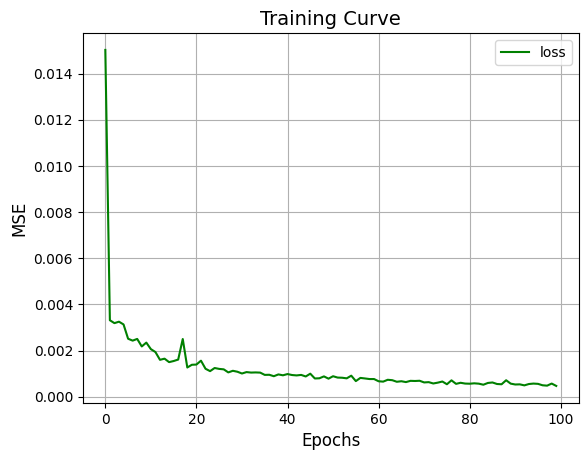

In [29]:
# Define model
reg = Sequential()

# -- LSTM layers --

# Input and first (hidden) layer (with dropout regularization)
reg.add(LSTM(units=60, return_sequences=True,
             input_shape=(X_train.shape[1], X_train.shape[2])))
reg.add(Dropout(0.1))

# Additional hidden layers
reg.add(LSTM(units=60, return_sequences=True))
reg.add(Dropout(0.1))
reg.add(LSTM(units=60, return_sequences=True))
reg.add(Dropout(0.1))
reg.add(LSTM(units=60, return_sequences=False))
reg.add(Dropout(0.1))

# Output layer
reg.add(Dense(units=X_train.shape[2]))

# Compile model
reg.compile(optimizer='adam', loss='mean_squared_error')

# Summarize LSTM model
reg.summary()

# Train (fit) model
history = reg.fit(X_train, y_train, batch_size=32, epochs=100)

# Plot loss during training (Mean Squared Error - MSE)
plt.plot(history.history['loss'], 'g', label='loss')
# Plot title and labels
plt.title('Training Curve', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('MSE', fontsize=12)
# Plot legend and grid
plt.legend()
plt.grid(True)

# Show loss results
plt.show()

#### Make predictions

In [30]:
# Get n (number of timesteps) previous stock prices for predicting
inputs = dataset[len(dataset)-len(dataset_test) - timesteps:]
# Reshape input values
inputs = inputs.reshape(-1, 1)
# Scale input values, directly apply transformations (already fitted)
inputs = sc.transform(inputs)

# Define test set structure
X_test = []
# For the entire test set:
for i in range(timesteps, timesteps + len(dataset_test)):
  # Range of values from i-60 to i, first column
  X_test.append(inputs[i-timesteps:i, 0])
# Convert to NumPy array
X_test = np.array(X_test)

# Obtain 3D structure of the test set
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Predict the test set results
predicted_stock_price = reg.predict(X_test)
# Apply inverse transformations
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
real_stock_price = sc.inverse_transform(dataset_test)

# Print predicted and real stock prices side-by-side (if required)
# print(np.concatenate((predicted_stock_price.reshape(len(predicted_stock_price), 1),
#                       real_stock_price.reshape(len(real_stock_price), 1)), 1 ))

# Print Scores
print('')
print('--- Prediction Scores ---')
print('')
# Mean Absolute Error (MAE)
print('MAE: %.3f' % (mean_absolute_error(real_stock_price, predicted_stock_price)))
# Mean Squared Error (MSE)
print('MSE: %.3f' % (mean_squared_error(real_stock_price, predicted_stock_price)))
# Root Mean Squared Error (RMSE)
print('RMSE: %.3f' % (mean_squared_error(real_stock_price, predicted_stock_price, squared=False)))
# R^2 Score (Goodness-of-Fit)
print('R^2 Score: %.3f%%' % (r2_score(real_stock_price, predicted_stock_price) * 100))

13/13 [==============================] - 2s 47ms/step

--- Prediction Scores ---

MAE: 0.859
MSE: 1.229
RMSE: 1.109
R^2 Score: 93.360%


#### Visualize Prediction Results

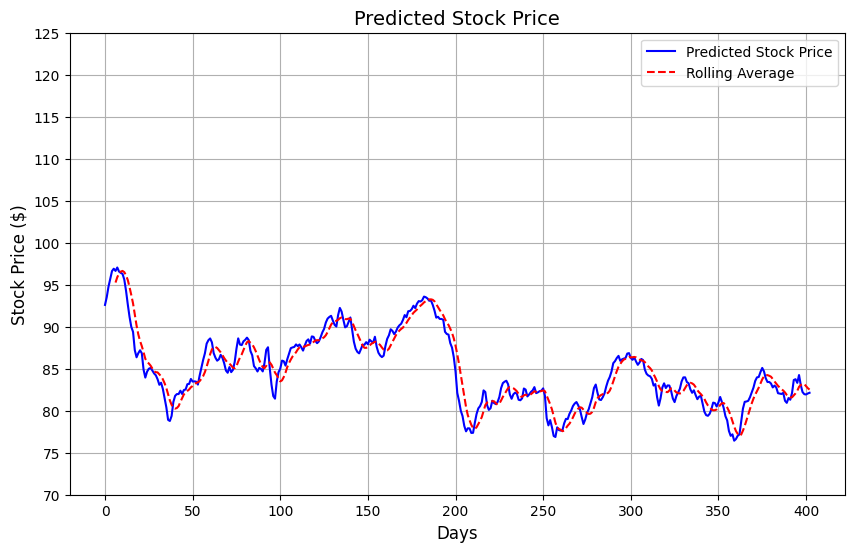

In [31]:
# Define figure
td_pred_results = plt.figure(figsize=(10,6))

# Plot results
td_pred_results = plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
# Plot rolling average (over 7 days)
df_real = pd.DataFrame(predicted_stock_price)
rolling_avg_pred = df_real.rolling(window = 7).mean()
td_pred_results = plt.plot(rolling_avg_pred, "--", color = 'red', label = 'Rolling Average')

# Adjust Y-Axis range
plt.yticks(np.arange(70, 130, 5))
# Plot title and labels
plt.xlabel('Days', fontsize=12)
plt.ylabel('Stock Price ($)', fontsize=12)
plt.title('Predicted Stock Price', fontsize=14)
# Plot legend and grid
plt.legend()
plt.grid(True)

# Show plot
plt.show()

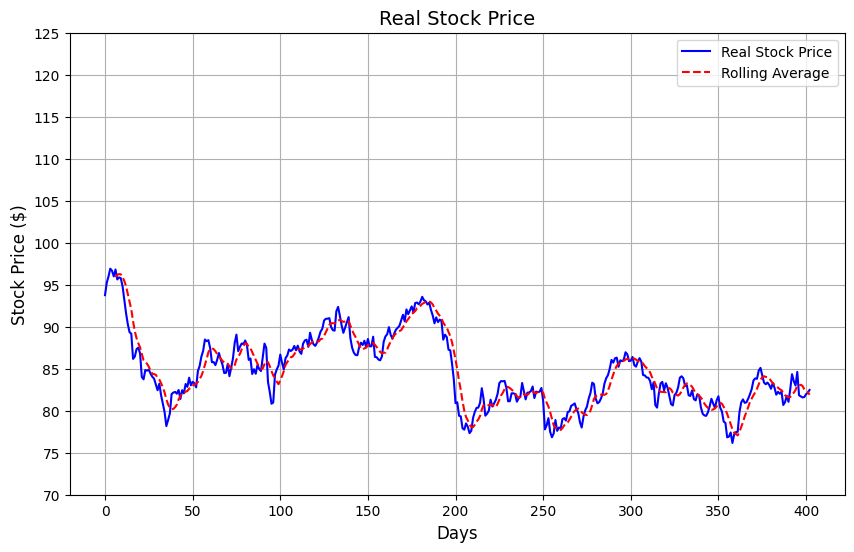

In [32]:
# Define figure
td_real_results = plt.figure(figsize=(10,6))

# Plot results
td_real_results = plt.plot(real_stock_price, color = 'blue', label = 'Real Stock Price')
# Plot rolling average (over 7 days)
df_real = pd.DataFrame(real_stock_price)
rolling_avg_real = df_real.rolling(window = 7).mean()
td_real_results = plt.plot(rolling_avg_real, "--", color = 'red', label = 'Rolling Average')

# Adjust Y-Axis range
plt.yticks(np.arange(70, 130, 5))
# Plot title and labels
plt.xlabel('Days', fontsize=12)
plt.ylabel('Stock Price ($)', fontsize=12)
plt.title('Real Stock Price', fontsize=14)
# Plot legend and grid
plt.legend()
plt.grid(True)

# Show plot
plt.show()

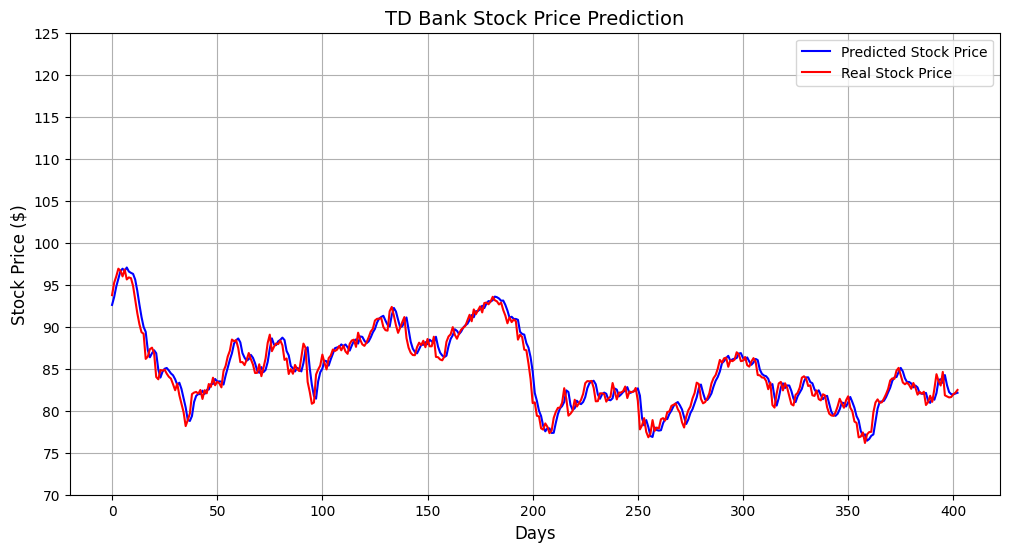

In [33]:
# Define results figure
td_results = plt.figure(figsize=(12,6))

# Plot results
td_results = plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
td_results = plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
# Adjust Y-Axis range
plt.yticks(np.arange(70, 130, 5))
# Plot title and labels
plt.xlabel('Days', fontsize=12)
plt.ylabel('Stock Price ($)', fontsize=12)
plt.title('TD Bank Stock Price Prediction', fontsize=14)
# Plot legend and grid
plt.legend(loc='upper right')
plt.grid(True)

# Show plot
plt.show()

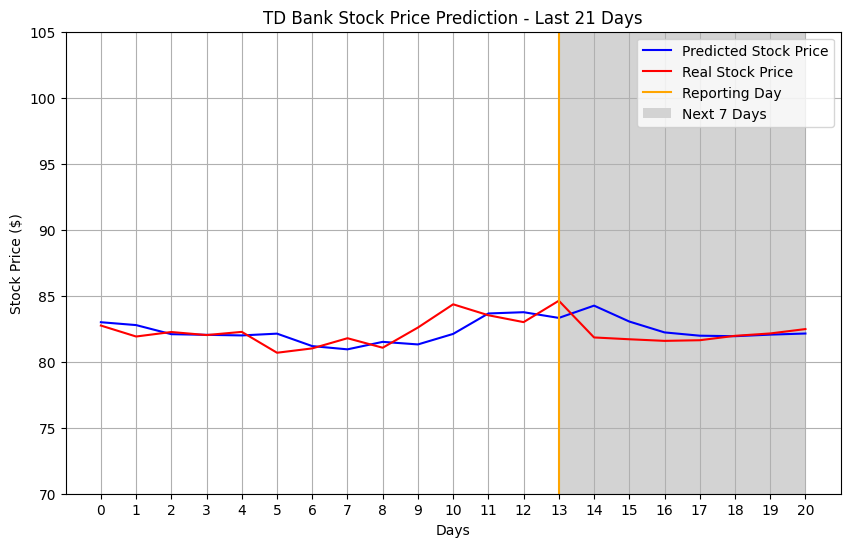

In [34]:
# Define results figure - Last 21 days
td_results_last_21 = plt.figure(figsize=(10,6))

# Plot results
# Predicted stock price
td_results_last_21 = plt.plot(predicted_stock_price[-21:], color = 'blue',
                              label = 'Predicted Stock Price')
# Real stock price
td_results_last_21 = plt.plot(real_stock_price[-21:], color = 'red',
                              label = 'Real Stock Price')
# (Current) reporting date
td_results_last_21 = plt.axvline(x=(len(real_stock_price[-21:])-(win+1)),
                                 color='orange', label = 'Reporting Day')
# Next 7 days (win)
td_results_last_21 = plt.axvspan(13, 20, facecolor='lightgrey', label='Next 7 Days')

# Adjust Y-Axis range
plt.xticks(np.arange(0, 21, 1))
plt.yticks(np.arange(70, 110, 5))
# Plot title and labels
plt.xlabel('Days')
plt.ylabel('Stock Price ($)')
plt.title('TD Bank Stock Price Prediction - Last 21 Days')
# Plot legend and grid
plt.legend(loc='upper right')
plt.grid(True)

# Show plot
plt.show()

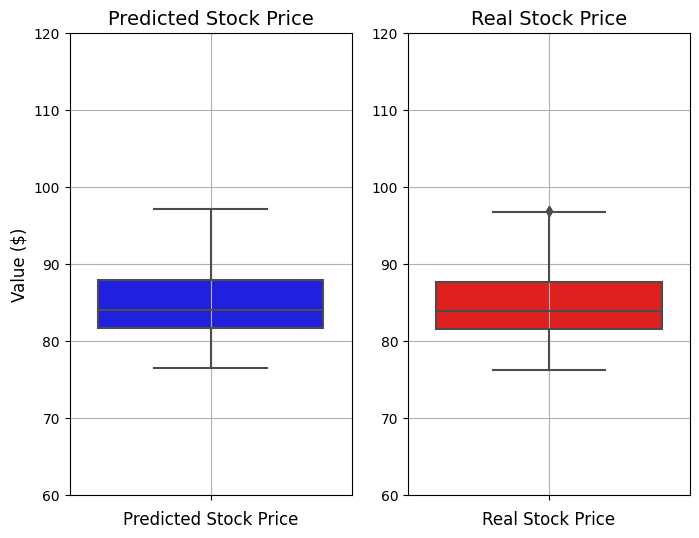

In [35]:
# Combined box plot distributions
box_plots_comb = plt.figure(figsize=(8, 6))

# Box plot for lr_pred
ax1 = box_plots_comb.add_subplot(1, 2, 1)
ax1 = sns.boxplot(y=predicted_stock_price, color='blue', orient='v')
# Adjust Y-Axis Range
plt.yticks(np.arange(60, 130, 10))
# Plot title and labels
plt.xlabel('Predicted Stock Price', fontsize=12)
plt.ylabel('Value ($)', fontsize=12)
plt.title('Predicted Stock Price', fontsize=14)
# Plot grid
plt.grid(True)

# Box plot for linear_svr_pred
ax2 = box_plots_comb.add_subplot(1, 2, 2)
ax2 = sns.boxplot(y=real_stock_price, color='red', orient='v')
# Adjust Y-Axis Range
plt.yticks(np.arange(60, 130, 10))
# Plot title and label
plt.xlabel('Real Stock Price', fontsize=12)
plt.title('Real Stock Price', fontsize=14)
# Plot grid
plt.grid(True)

# Show subplot
plt.show()

In [36]:
# Calculate run time
run_time = time.time() - start_time
run_time_min = int(run_time / 60)
run_time_sec = int(run_time % 60)
print("Run Time: " + str(np.round(run_time_min, 0)) + ":" + str(np.round(run_time_sec, 2)))

Run Time: 10:23
